In [11]:
import numpy as np
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

import MFCC_computation as util
reload(util)

%matplotlib inline

In [55]:
import glob
import os

path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
}

MFCC_COEFFS = 13

### MFCC Visualization

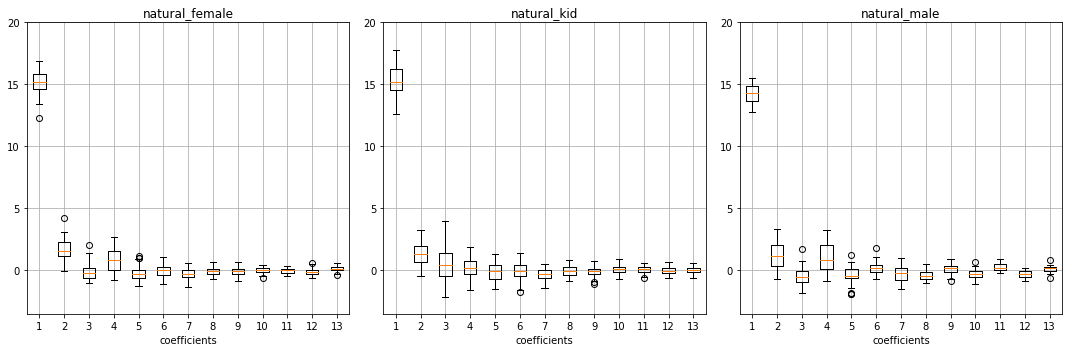

In [56]:
util.print_coeff_boxplot(['natural_female', 'natural_kid', 'natural_male'], FILES, nceps=MFCC_COEFFS, ylim=(-3.5, 20))

## MAN vs. WOMAN vs. KIS

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

dataset[0]	[ 14.96102865   0.0756482   -0.82505983   2.28844402  -0.3912683
  -0.21701203  -0.01501354   0.06130955  -0.03899742  -0.49679021
   0.49969926  -0.66154528   0.27916221  -1.          -1.           1.        ] 

input[0]	[ 14.96102865   0.0756482   -0.82505983   2.28844402  -0.3912683
  -0.21701203  -0.01501354   0.06130955  -0.03899742  -0.49679021
   0.49969926  -0.66154528   0.27916221] 

ouput[0]	[-1. -1.  1.] 

testing 8 neurons...


testing 32 neurons...


testing 64 neurons...


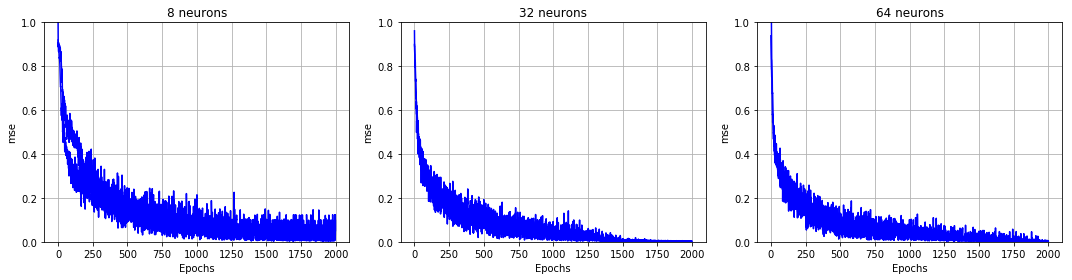

In [83]:
N_INITS = 2
EPOCHS = 2000
N_NEURONS = [8, 32, 64]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

dataset = util.create_dataset(
    [('natural_kid', [1, -1, -1]), ('natural_female', [-1, 1, -1]), ('natural_male', [-1, -1, 1])], FILES, MFCC_COEFFS)

dataset_input = dataset[:, :-3]  # filter only input values (n-1 first values)
dataset_output = dataset[:, -3:]  # filter only the output class (last value)

print "dataset[0]\t", dataset[0], "\n"
print "input[0]\t", dataset_input[0], "\n"
print "ouput[0]\t", dataset_output[0], "\n"

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 3], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

util.print_mse(MSE, N_NEURONS)

In [38]:
util.create_dataset([('natural_male', )], FILES)

ValueError: too many values to unpack

In [17]:
EPOCHS = 1000
N_NEURONS = [8, 32, 64]
K = 3

Testing 8 neurons...


Testing 32 neurons...


Testing 64 neurons...


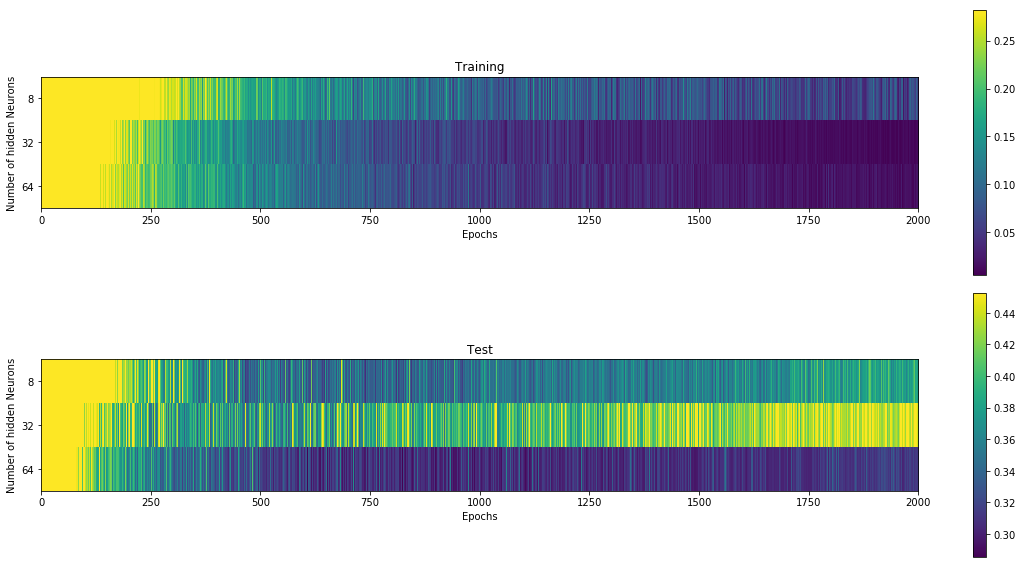

In [85]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))
reload(cv)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 3], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=0,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=100)

### Final Model and performance

In [86]:
MOMENTUM = 0.5
EPOCHS = 2000
LEARNING_RATE = 0.001
N_NEURONS = 64
N_INITS = 2

precision:	0.827
recall:	0.806
f1_score:	0.81
MSE training:	0.00394995942162
MSE test:	0.399416441101
Confusion matrix:
[[ 28.   9.   0.]
 [  4.  30.   1.]
 [  1.   6.  29.]]


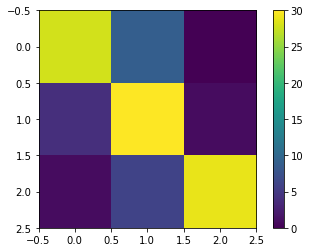

In [87]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 3], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

conclusion here..